In [1]:

import tensorflow as tf
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.utils import to_categorical, plot_model
from sklearn.metrics import confusion_matrix, accuracy_score, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np
import os


In [2]:
np.random.seed(42)
tf.random.set_seed(42)

#  بارگذاری مجموعه داده MNIST
(X_train, y_train), (X_test, y_test) = mnist.load_data()


print(f"شکل داده‌های آموزش: X={X_train.shape}, y={y_train.shape}")
print(f"شکل داده‌های تست: X={X_test.shape}, y={y_test.shape}")



11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
شکل داده‌های آموزش: X=(60000, 28, 28), y=(60000,)
شکل داده‌های تست: X=(10000, 28, 28), y=(10000,)


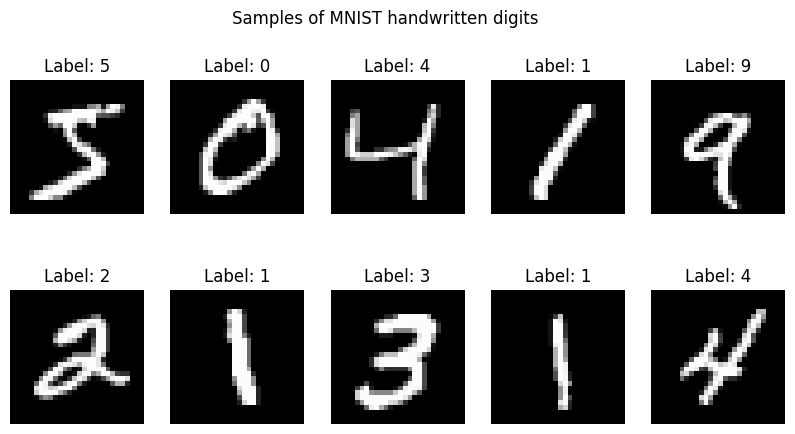

In [3]:

# نمایش چند تصویر نمونه
plt.figure(figsize=(10, 5))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    plt.imshow(X_train[i], cmap='gray')
    plt.title(f"Label: {y_train[i]}")
    plt.axis('off')
plt.suptitle('Samples of MNIST handwritten digits')
plt.show()


#پیش‌پردازش داده‌ها


In [4]:
X_train = X_train.reshape((X_train.shape[0], 28, 28, 1))
X_test = X_test.reshape((X_test.shape[0], 28, 28, 1))

# نرمال‌سازی مقادیر پیکسل‌ها به بازه [0, 1]
X_train = X_train.astype('float32') / 255.0
X_test = X_test.astype('float32') / 255.0

# One-Hot Encoding برای برچسب‌های خروجی
y_train_encoded = to_categorical(y_train, num_classes=10)
y_test_encoded = to_categorical(y_test, num_classes=10)

print(f"شکل داده‌های آموزش پس از تغییر شکل و نرمال‌سازی: {X_train.shape}")
print(f"شکل برچسب‌های آموزش پس از One-Hot Encoding: {y_train_encoded.shape}")



شکل داده‌های آموزش پس از تغییر شکل و نرمال‌سازی: (60000, 28, 28, 1)
شکل برچسب‌های آموزش پس از One-Hot Encoding: (60000, 10)


#ساخت مدل CNN

In [5]:

model = Sequential([

    Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)),
    # لایه Pooling: کاهش ابعاد مکانی (2x2)
    MaxPooling2D((2, 2)),

    # لایه کانولوشنی دوم: 64 فیلتر 3x3
    Conv2D(64, (3, 3), activation='relu'),
    # لایه Pooling دوم
    MaxPooling2D((2, 2)),

    Flatten(),

    # لایه Dense (Fully Connected) اول
    Dense(units=128, activation='relu'),
    # Dropout برای کاهش Overfitting (50% از نورون‌ها را خاموش می‌کند)
    Dropout(0.5),

    # لایه خروجی: 10 نورون برای 10 رقم (0-9)

    Dense(units=10, activation='softmax')
])


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


#کامپایل مدل

In [8]:


model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

print("\n--- خلاصه مدل و تعداد پارامترها ---")
model.summary()





--- خلاصه مدل و تعداد پارامترها ---


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 26, 26, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 13, 13, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 11, 11, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 5, 5, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1600)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       204,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 225,034 (879.04 KB)

 Trainable params: 225,034 (879.04 KB)

 Non-trainable params: 0 (0.00 B)

#آموزش مدل

In [10]:
history = model.fit(X_train, y_train_encoded,
                    epochs=10,
                    batch_size=128,
                    validation_split=0.1, # 10% از داده‌های آموزش برای اعتبارسنجی
                    verbose=1)




Epoch 1/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 45s 107ms/step - accuracy: 0.8552 - loss: 0.4755 - val_accuracy: 0.9815 - val_loss: 0.0605
Epoch 2/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 46s 109ms/step - accuracy: 0.9678 - loss: 0.1084 - val_accuracy: 0.9860 - val_loss: 0.0446
Epoch 3/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 79s 102ms/step - accuracy: 0.9759 - loss: 0.0783 - val_accuracy: 0.9887 - val_loss: 0.0379
Epoch 4/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 82s 102ms/step - accuracy: 0.9815 - loss: 0.0640 - val_accuracy: 0.9883 - val_loss: 0.0384
Epoch 5/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 43s 101ms/step - accuracy: 0.9838 - loss: 0.0531 - val_accuracy: 0.9900 - val_loss: 0.0338
Epoch 6/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 93s 128ms/step - accuracy: 0.9860 - loss: 0.0449 - val_accuracy: 0.9912 - val_loss: 0.0339
Epoch 7/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 43s 102ms/step - accuracy: 0.9897 - loss: 0.0351 - val_accuracy: 0.9912 - val_loss: 0.0309
Epoch 8/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 78s 94ms/step - accuracy: 0.9896 - loss: 0.

#ارزیابی مدل

In [11]:
loss, accuracy = model.evaluate(X_test, y_test_encoded, verbose=0)
print(f"دقت مدل روی داده‌های تست: {accuracy*100:.2f}%")
print(f"مقدار تابع هزینه روی داده‌های تست: {loss:.4f}")


دقت مدل روی داده‌های تست: 99.32%
مقدار تابع هزینه روی داده‌های تست: 0.0228


#ماتریس آشفتگی

In [21]:

#  پیش‌بینی و ماتریس آشفتگی
y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)

# محاسبه ماتریس آشفتگی
cm = confusion_matrix(y_test, y_pred)


313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step


<Figure size 1000x800 with 0 Axes>

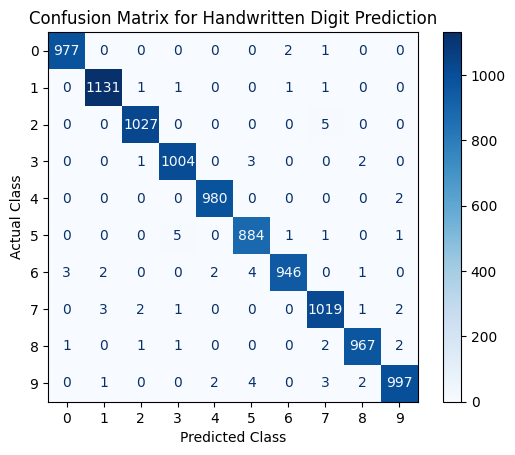

In [13]:
# رسم ماتریس آشفتگی
plt.figure(figsize=(10, 8))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=range(10))
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix for Handwritten Digit Prediction')
plt.xlabel('Predicted Class')
plt.ylabel('Actual Class')
plt.show()


# رسم نمودارهای دقت و تابع هزینه

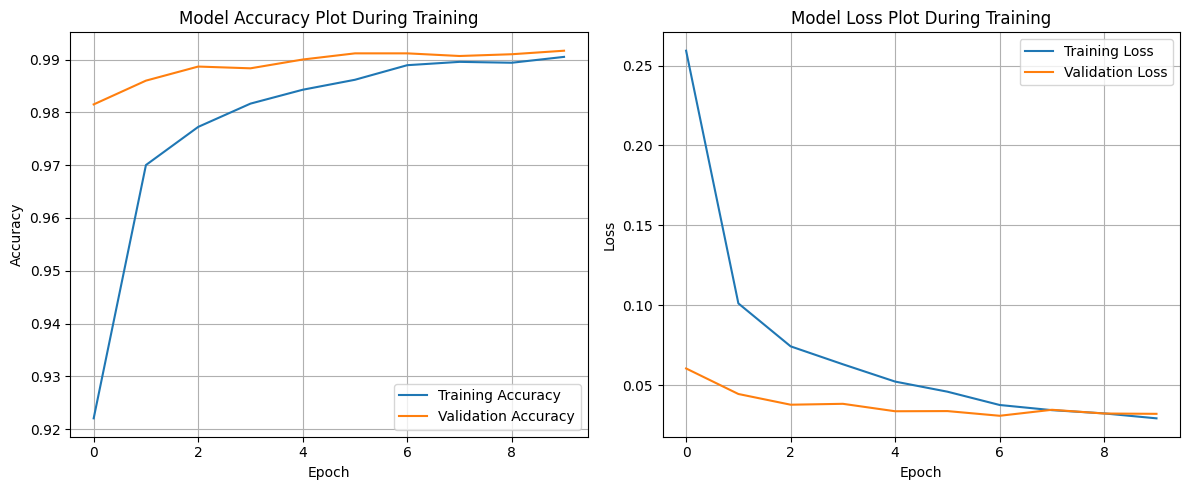

In [20]:

plt.figure(figsize=(12, 5))

# نمودار دقت
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy Plot During Training')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# نمودار تابع هزینه
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Plot During Training')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

model_filename = 'mnist_cnn_model.h5'
model.save(model_filename)

# پیش‌بینی روی تصویر نمونه

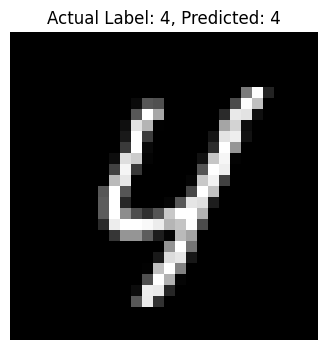

کلاس واقعی تصویر نمونه: 4
کلاس پیش‌بینی شده برای تصویر نمونه: 4


In [26]:
sample_index = 555
sample_image = X_test[sample_index]
sample_label = y_test[sample_index]

sample_image_reshaped = np.expand_dims(sample_image, axis=0)

# پیش‌بینی کلاس تصویر نمونه
predicted_class = np.argmax(predicted_probs, axis=1)[0]

# نمایش تصویر نمونه و نتیجه پیش‌بینی
plt.figure(figsize=(4, 4))
plt.imshow(sample_image.squeeze(), cmap='gray') # از squeeze برای حذف بعد اضافه استفاده می‌کنیم
plt.title(f"Actual Label: {sample_label}, Predicted: {predicted_class}")
plt.axis('off')
plt.show()

print(f"کلاس واقعی تصویر نمونه: {sample_label}")
print(f"کلاس پیش‌بینی شده برای تصویر نمونه: {predicted_class}")